In [1]:
#import packages
import argparse
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import scipy.io
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
import sys

utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

from rsm_utils import get_flat_lower_tri, get_reliability_data 

data_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/data/'
local_data_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/local_data/'


In [2]:
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [3]:
subjid = '06'
hemi = 'rh'
roi_name = 'tessellate_300'

In [4]:
n_repeats = 3

#get ROI data
parcels = []
mgh_file = mgh.load(local_data_dir+'freesurfer/subj'+ subjid +'/' + hemi + '.' + roi_name + '.mgz')
parcels.append(mgh_file.get_fdata()[:,0,0])

num_rois = int(np.max(parcels))

#get trial ids and mask        
all_ids = []
max_session = np.zeros(len([subjid]))
for sidx, sid in enumerate([subjid]):

    data = pd.read_csv(data_dir+'nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')

    max_session[sidx] = np.max(np.array(data['SESSION'])) 

    all_ids.append(np.array(data['73KID']))

which_reps = []
for sidx, sid in enumerate([subjid]):
    vals, idx_start, count = np.unique(all_ids[sidx], return_counts=True,
                                    return_index=True)
    which_reps.append(vals[count == n_repeats])

least_trials = min(which_reps, key=len)

id_nums_3reps = []
mask_3reps = []
for sidx, sid in enumerate([subjid]):

    data = pd.read_csv(data_dir+'nsddata/ppdata/subj'+ sid +'/behav/responses.tsv', sep='\t')

    mask_3reps.append(np.isin(all_ids[sidx],which_reps[sidx]))
    id_nums_3reps.append(np.array(data['73KID'])[mask_3reps[sidx]])

arr1inds = id_nums_3reps[sidx].argsort()

#get and sort z-scored betas
betas_by_ROI = [[] for j in range(num_rois)]

In [5]:
for sidx, sid in enumerate([subjid]):
        
    mask = mask_3reps[sidx]
    sorted_betas = []

    #get all betas across all sessions
    for sess in range(1,int(max_session[sidx])+1):
        print(sess)

        if(sess < 10):
            idx = '0' + str(sess)
        else:
            idx = str(sess)

        raw_betas = h5py.File(local_data_dir+'freesurfer/subj'+sid+'/betas/'+ hemi +'.zscore_betas_session'+idx+'.hdf5','r')

        sess_betas = raw_betas['zscore_betas'][:][mask[(sess-1)*750:sess*750]]
        del raw_betas

        if(sess==1):
            for roi_idx in range(num_rois):
                betas_by_ROI[roi_idx] = sess_betas[:,parcels[sidx] == roi_idx+1]
        else:
            for roi_idx in range(num_rois):
                betas_by_ROI[roi_idx] = np.append(betas_by_ROI[roi_idx],sess_betas[:,parcels[sidx] == roi_idx+1],axis=0)

        del sess_betas

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [6]:
betas_by_repeat_by_ROI = [[[] for j in range(num_rois)] for i in range(len([subjid]))]
for sidx, sid in enumerate([subjid]):
    for roi_idx in range(num_rois):  

        sorted_betas = betas_by_ROI[roi_idx][arr1inds[::-1]]

        for r in range(n_repeats):
            betas_by_repeat_by_ROI[sidx][roi_idx].insert(r,sorted_betas[r::3])

In [7]:
del betas_by_ROI

In [9]:
num_rois = 15 #for testing

In [42]:
#Create RSMS for all the ROIs, repeats and subjects
tril_flat_shape = int((betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm0 = np.zeros((num_rois, tril_flat_shape))
flat_rsm1 = np.zeros((num_rois, tril_flat_shape))
flat_rsm2 = np.zeros((num_rois, tril_flat_shape))

sidx = 0 #currently doing one subject at a time
for roi_idx in range(num_rois):
    for r in range(n_repeats):
        rsm = np.corrcoef(betas_by_repeat_by_ROI[sidx][roi_idx][r])
        if r == 0:        
            flat_rsm0[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)
        elif r == 1:
            flat_rsm1[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)
        elif r == 2:
            flat_rsm2[roi_idx, :] = get_flat_lower_tri(rsm,diagonal=False)
            
r1_trial_order = [0, 0, 1, 1, 2, 2]
r2_trial_order = [1, 2, 0, 2, 0, 1]

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


In [43]:
# get NC for each ROI
NC = np.zeros((num_rois))
for ridx in range(num_rois):
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(flat_rsm0[ridx,:],flat_rsm1[ridx,:])[0],
                stats.pearsonr(flat_rsm0[ridx,:],flat_rsm2[ridx,:])[0],
                stats.pearsonr(flat_rsm1[ridx,:],flat_rsm2[ridx,:])[0]]
    NC[ridx] = np.mean(split_half) * 100

In [44]:
roi_idx1 = 1
y = flat_rsm1[roi_idx1,:] # 1 x k
X = flat_rsm2 # N x k

In [50]:
row * np.sqrt(100/NC[roi_idx]) * np.sqrt(100/NC)

array([0.39446071, 0.86874811, 0.26051064, 0.54842676, 0.46707846,
       0.14025861, 0.33491857, 0.18437761, 0.36558708, 0.14414396,
       0.25078876, 0.27746219, 0.14799633, 0.30996067, 0.25932387])

In [23]:
row[0] * np.sqrt(100/NC[0]) * np.sqrt(100/NC[0]) 

0.8650302397575693

In [68]:
print('starting mega matrix')
#make the mega matrix!
mega_matrix = np.zeros((num_rois,num_rois))

for roi_idx1 in range(num_rois): #rows - i.e. model candidate
    
    row = np.zeros((6,num_rois))
    for r in range(6): #loop through combos
        
        if r == 0:
            y = flat_rsm0[roi_idx1,:] # 1 x k
            X = flat_rsm1 # N x k
        elif r == 1:
            y = flat_rsm0[roi_idx1,:] # 1 x k
            X = flat_rsm2 # N x k
        elif r == 2:
            y = flat_rsm1[roi_idx1,:] # 1 x k
            X = flat_rsm0 # N x k
        elif r == 3:
            y = flat_rsm1[roi_idx1,:] # 1 x k
            X = flat_rsm2 # N x k
        elif r == 4:
            y = flat_rsm2[roi_idx1,:] # 1 x k
            X = flat_rsm0 # N x k
        elif r == 5:
            y = flat_rsm2[roi_idx1,:] # 1 x k
            X = flat_rsm1 # N x k
        
        row[r,:] = vcorrcoef(X,y)
    
    mega_matrix[roi_idx1,:] = np.mean(row, axis = 0) * np.sqrt(100/NC[roi_idx1]) * np.sqrt(100/NC)


starting mega matrix


In [55]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

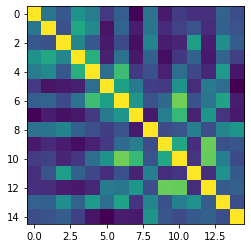

In [69]:
plt.imshow(mega_matrix)

In [70]:
mega_matrix

array([[1.        , 0.442854  , 0.33201329, 0.54844006, 0.46990526,
        0.23145292, 0.35318032, 0.08962871, 0.42661122, 0.14802905,
        0.24209202, 0.20334039, 0.20892263, 0.36818587, 0.30156304],
       [0.442854  , 1.        , 0.30759358, 0.62676796, 0.51486538,
        0.12798377, 0.374009  , 0.14843781, 0.43579779, 0.19279006,
        0.26273667, 0.31499662, 0.19564988, 0.36641088, 0.31653134],
       [0.33201329, 0.30759358, 1.        , 0.50085859, 0.33430029,
        0.14695183, 0.28521205, 0.12025234, 0.49418966, 0.15198305,
        0.17769607, 0.59041161, 0.15168635, 0.52937325, 0.35148496],
       [0.54844006, 0.62676796, 0.50085859, 1.        , 0.66093279,
        0.16203361, 0.42323574, 0.14095323, 0.36461237, 0.11303817,
        0.22811622, 0.36482146, 0.14369826, 0.37208479, 0.25303753],
       [0.46990526, 0.51486538, 0.33430029, 0.66093279, 1.        ,
        0.41249281, 0.71572042, 0.23711467, 0.3041826 , 0.16379174,
        0.41194391, 0.28101883, 0.18117278, 